In [251]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage.io
from skimage.segmentation import clear_border
from skimage.filters import threshold_mean
from skimage.morphology import convex_hull_object, remove_small_objects
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import itertools
from shutil import copyfile

In [15]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [125]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    fig_width_pt = width_pt * fraction
    inches_per_pt = 1 / 72.27
    golden_ratio = (5**.5 - 1) / 2
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# Analysis of raw data

In [16]:
data_dir = '/Users/beantown/PycharmProjects/master-thesis/data/raw/'
processed_dir = '/Users/beantown/PycharmProjects/master-thesis/data/processed/'

In [17]:
def get_estimated_resulution(file_name):
    data_dir = '/Users/beantown/PycharmProjects/master-thesis/data/raw/'
    fpath = data_dir + file_name + '.jpg'
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # red color boundaries [B, G, R]
    lower = [55, 55, 55]
    upper = [70, 255, 255]

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)
    #ret,thresh = cv2.threshold(mask, 20, 255, 9)
    #contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    #result = np.hstack([image, output])
    result = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    gray_img = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    
    contours = find_contours(gray_img, 0.8)
    
    Xlength = 0
    Ylength = 0

    for contour in contours:
        # get corners
        Xmin = np.min(contour[:,1])
        Xmax = np.max(contour[:,1])
        Ymin = np.min(contour[:,0])
        Ymax = np.max(contour[:,0])

        # get current pixel length for x and y-axis
        Xlength_new = abs(Xmin - Xmax)
        Ylength_new = abs(Ymin - Ymax)

        if Xlength_new > Xlength:
            Xlength = Xlength_new
            Ylength = Ylength_new

    # calculate pixels / cm (2.3 is given by the ruler of the site of images)
    Ylength = Ylength / 2.3
    Xlength = Xlength / 2.3
    
    #print(f'sucessfully calculated resolution for {file_name}')
    
    return [Ylength, Xlength]

In [18]:
def get_info(path):
    info_path = join(path, 'info.csv')
    if isfile(info_path): 
        info_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames':str,'papyID':int,'posinfo':str, 'pixelCM_Y':float, 'pixelCM_X':float}, header=0)
    else:
        fnames = [f for f in listdir(path) if isfile(join(path, f))]
        fnames = [ x for x in fnames if ".jpg" in x ]
        fnames = [f.split('.',1)[0] for f in fnames]
        info_frame = pd.DataFrame(fnames, columns=['fnames'])
        info_frame['papyID'] = info_frame.fnames.apply(lambda x: x.split('_',1)[0])
        info_frame['posinfo'] = info_frame.fnames.apply(lambda x: ''.join(filter(str.isalpha, x)))
        info_path = join(path, 'info.csv')
        info_frame['pixelCentimer'] = info_frame.fnames.progress_apply(get_estimated_resulution)
        split_info_frame = pd.DataFrame(info_frame['pixelCentimer'].tolist(), columns=['pixelCM_Y','pixelCM_X'])
        info_frame = pd.concat([info_frame, split_info_frame], axis=1)
        info_frame.drop('pixelCentimer', axis=1, inplace=True)
        #ToDo split it into too columns!!!


        # The following lines are a workaround for a mistake in the get_estimate... function. Resolution has to be same size, but code calcualte the size of the box. If you take the max here you are just fine since the result gives us alwasys what we want.
        info_frame['pixelCM'] = info_frame[['pixelCM_Y','pixelCM_X']].max(axis=1)
        info_frame.drop(columns=['pixelCM_X','pixelCM_Y'], inplace=True)

        info_frame.to_csv(info_path)
    return info_frame

In [19]:
info_frame = get_info(data_dir)

In [20]:
info_frame

,fnames,papyID,posinfo,pixelCM
0,11930_4233V,11930,V,231.298834
1,13947_4857DV,13947,DV,227.384677
2,10812_4101KR,10812,KR,228.253931
3,13912_4803FV,13912,FV,229.122153
4,10752_4097Z20R,10752,ZR,412.601164
...,...,...,...,...
8847,12086_4240LV,12086,LV,228.255498
8848,11368_4139BR,11368,BR,139.123257
8849,15493_3585WR,15493,WR,227.384945
8850,8607_2155R,8607,R,229.990194


In [21]:
id_series = info_frame.groupby('papyID')['fnames'].nunique().sort_values(ascending=False)

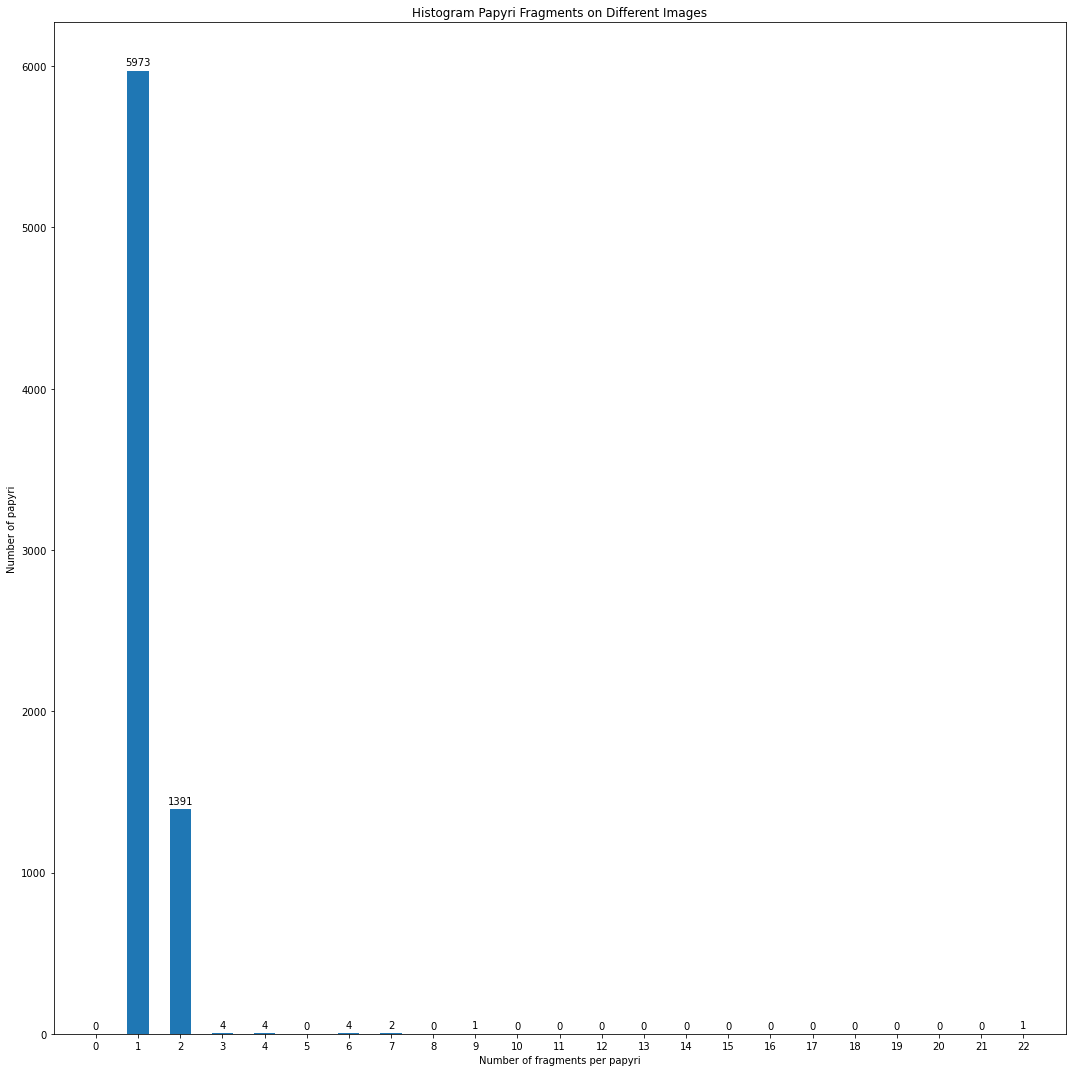

In [22]:
counts = np.bincount(id_series)

fig, ax = plt.subplots(figsize=(15,15))
rects = ax.bar(range(23), counts, width=.5, align='center')
ax.set(xticks=range(23), xlim=[-1, 23], title='Histogram Papyri Fragments on Different Images', ylabel='Number of papyri',xlabel='Number of fragments per papyri')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)

fig.tight_layout()

plt.show()

In [23]:
info_frame

,fnames,papyID,posinfo,pixelCM
0,11930_4233V,11930,V,231.298834
1,13947_4857DV,13947,DV,227.384677
2,10812_4101KR,10812,KR,228.253931
3,13912_4803FV,13912,FV,229.122153
4,10752_4097Z20R,10752,ZR,412.601164
...,...,...,...,...
8847,12086_4240LV,12086,LV,228.255498
8848,11368_4139BR,11368,BR,139.123257
8849,15493_3585WR,15493,WR,227.384945
8850,8607_2155R,8607,R,229.990194


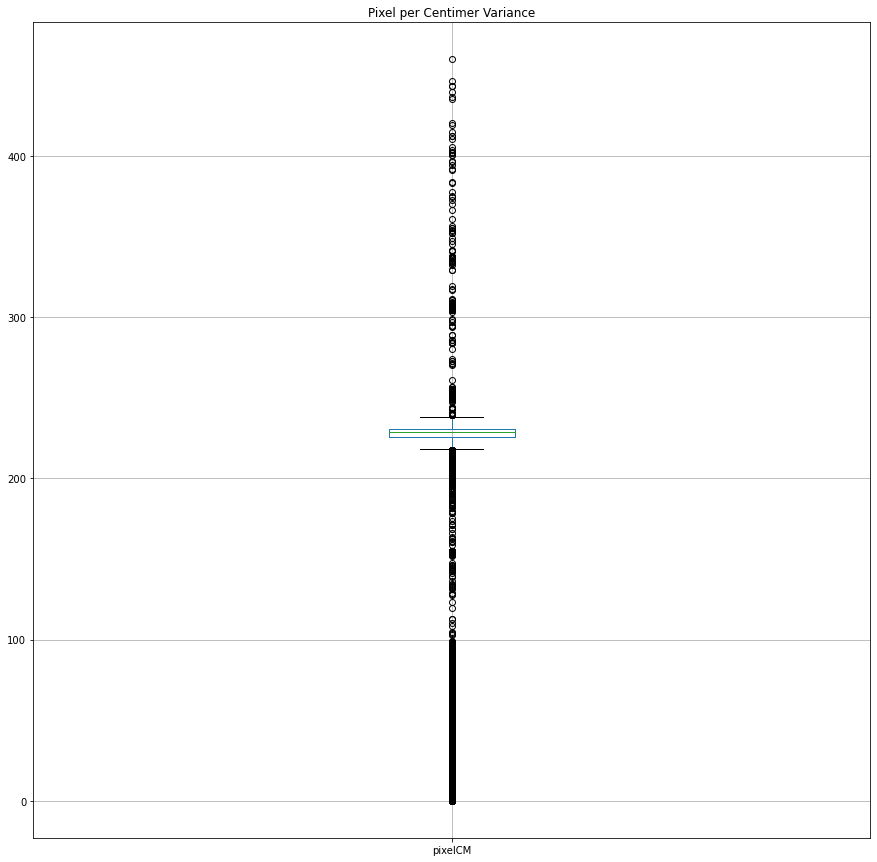

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Pixel per Centimer Variance')
info_frame[['pixelCM']].boxplot()
plt.show()

# Make Dataset

### Goals
- Crop Images such that colour scale is no longer visible
- Separate fragments which are on one image

### Algorithm
1. First get the median color values arround the center
2. Binarize the image (values which are close to a specified threshold keep the same. Everything else shall be white
3. Find bounding boxes
4. Crop images.

In [25]:
def clear_data(processed_dir, data_dir,  threshold=90):
    # Copy images from raw in processed folder before doing any actions to ensure the images a processed with all specified steps.
    # Copy also the info.file since we need it to propagate properley
    file_numb_processed = len([name for name in os.listdir(processed_dir) if os.path.isfile(os.path.join(processed_dir, name))])
    file_numb_raw = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])
    print(f'{file_numb_processed = }')
    print(f'{file_numb_raw = }')

    # TODO Change this such that it fit's real live situation -> get's just exceuted if neccecary
    # copy imgs and file
    if file_numb_processed != file_numb_raw:
        print('Empty processed dir and copy everything from the raw dir.')
        !rm /Users/beantown/PycharmProjects/master-thesis/data/processed/*
        !cp -a /Users/beantown/PycharmProjects/master-thesis/data/raw/ /Users/beantown/PycharmProjects/master-thesis/data/processed/

        # get df with processed data
        info_frame = get_info(processed_dir)
        # drop na
        info_frame.dropna(inplace=True)
        # drop every row which is greater than threshold aka img resolution is to low to be plausible
        info_frame = info_frame[info_frame.pixelCM > threshold]

        def get_low_contrase_info(file_name):
            processed_dir = '/Users/beantown/PycharmProjects/master-thesis/data/processed/'
            fpath = processed_dir + file_name + '.jpg'
            image = skimage.io.imread(fpath)
            return skimage.exposure.is_low_contrast(image, fraction_threshold=0.05, lower_percentile=1, upper_percentile=99, method='linear')

        info_frame['lowRes'] = info_frame.fnames.progress_apply(get_low_contrase_info)
        info_frame = info_frame[info_frame.lowRes == False]
        temp_frame = info_frame.copy()
        temp_frame['fnamesType'] =  temp_frame['fnames'] + '.jpg'
        file_names = temp_frame['fnamesType'].tolist()


        info_frame.to_csv(processed_dir + 'info.csv')

        return info_frame
    else:
        info_frame = get_info(processed_dir)
        info_frame.fnames = info_frame.fnames.astype(str)
        return get_info(processed_dir)

In [26]:
#processed_info_frame = clear_data(processed_dir=processed_dir, data_dir=data_dir,  threshold=90)

In [28]:
def enhanced_connected_components(filename, sigma=1.0, t=0.5, connectivity=2, min_area=0):
    image = skimage.io.imread(filename)
    gray_image = skimage.color.rgb2gray(image)
    blurred_image = skimage.filters.gaussian(gray_image, sigma=sigma)
    binary_mask = blurred_image < t
    labeled_image, count = skimage.measure.label(object_mask,
                                                 connectivity=connectivity, return_num=True)
    return labeled_image, count

In [29]:
def get_natural_fragments(fname):
    
    
    output_path = '/Users/beantown/PycharmProjects/master-thesis/data/processed/02_post_natural_fragmenting/'
    plot=False
    processed_dir = '/Users/beantown/PycharmProjects/master-thesis/data/processed/01_post_cleansing/'
    #fname_rand=False
    ''' FOR DEBUG 
    if fname_rand:
        fname = np.random.choice(processed_info_frame.sample(1).fnames.to_list())
    else: 
        fname = '12830_4433LR'
    
    '''
   
    sigma=10.0
    buffer_size = 20
    connectivity=2
    min_area=100000
        
    fpath = processed_dir + fname + '.jpg'
    image = skimage.io.imread(fpath)
    gray = rgb2gray(image)
    blurred_image = skimage.filters.gaussian(gray, sigma=sigma)
    histogram, bin_edges = np.histogram(blurred_image, bins=256, range=(0.0, 1.0))
    t = threshold_mean(blurred_image)
    binary_mask = blurred_image < t
    cleared_binary_mask = clear_border(binary_mask, buffer_size=buffer_size)
    chull = convex_hull_object(cleared_binary_mask)
    object_mask = skimage.morphology.remove_small_objects(chull, min_area)
    labeled_image, count = skimage.measure.label(object_mask, connectivity=connectivity, return_num=True)
    
    colored_label_image = skimage.color.label2rgb(labeled_image, bg_label=0)
    object_features = skimage.measure.regionprops(labeled_image)
    
    
    
    for frag_count, region in enumerate(object_features):
        skimage.io.imsave(output_path + str(frag_count)+ '_' + fname + '.png', image[region.slice])
    
    object_areas = [objf["area"] for objf in object_features]
    
    
    
    if plot:
        print(f'Found {count}# objects\n')
        
        fig = plt.figure(figsize=(60, 60))
        rows = 4
        columns = 2

        fig.add_subplot(rows, columns, 1)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Gray Scale Image {fname}', fontsize=26)
        plt.imshow(gray, cmap='gray')

        fig.add_subplot(rows, columns, 2)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Blurred Image with {sigma = }', fontsize=26)
        plt.imshow(blurred_image, cmap='gray')

        fig.add_subplot(rows, columns, 3)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.plot(bin_edges[0:-1], histogram)
        plt.title("Graylevel histogram", fontsize=26)
        plt.xlabel("gray value")
        plt.ylabel("pixel count")
        plt.xlim(0, 1.0)

        fig.add_subplot(rows, columns, 4)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Binary image with thrshold {t = }', fontsize=26)
        plt.imshow(binary_mask, cmap='gray')

        fig.add_subplot(rows, columns, 5)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Binary image without boarder and {buffer_size = }', fontsize=26)
        plt.imshow(cleared_binary_mask, cmap='gray')

        fig.add_subplot(rows, columns, 6)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Denoised Mask / Convex Hull {buffer_size = }', fontsize=26)
        plt.imshow(chull, cmap='gray')
        
        fig.add_subplot(rows, columns, 7)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.xlabel("Area (pixels)")
        plt.ylabel("Number of objects")
        plt.title('Histogram of Object sizes', fontsize=26)
        plt.hist(object_areas)
        
        fig.add_subplot(rows, columns, 8)
        plt.xticks(fontsize=26)
        plt.yticks(fontsize=26)
        plt.title(f'Labled Image', fontsize=26)
        plt.imshow(colored_label_image)

        plt.savefig(fname + '.pdf', format='pdf')
        plt.tight_layout()
        plt.show()
    #return object_areas, slices_temp

In [30]:
#object_areas, slices_temp = get_natural_fragments(fname_rand=True, plot=True)

In [42]:
def retrive_size_by_fname(fname):
    path = '/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing/'
    info_frame = get_info(path=path)
    return float(info_frame.loc[info_frame['fnames'] == fname]['pixelCM'])

In [43]:
def create_processed_info(path):
    info_path = join(path, 'processed_info.csv')
    if isfile(info_path):
        processed_frame = pd.read_csv(info_path, index_col=0, dtype={'fnames':str,'papyID':int,'posinfo':str, 'pixelCentimer':float}, header=0)    
    else:    
        fnames = [f for f in listdir(path) if isfile(join(path, f))]
        fnames = [ x for x in fnames if ".png" in x ]
        fnames = [f.split('.',1)[0] for f in fnames]
        fnames_frame = pd.DataFrame(fnames,columns=['fnames'])
        fragmentID = pd.DataFrame([f.split('_',1)[0] for f in fnames], columns=['fragmentID'])
        fnames_raw = [f.split('_',1)[1] for f in fnames]
        processed_frame = pd.DataFrame(fnames_raw, columns=['fnames_raw'])

        processed_frame = pd.concat([processed_frame, fnames_frame], axis=1)

        processed_frame = pd.concat([processed_frame, fragmentID], axis=1)
        processed_frame['papyID'] = processed_frame.fnames_raw.apply(lambda x: x.split('_',1)[0])
        processed_frame['posinfo'] = processed_frame.fnames_raw.apply(lambda x: ''.join(filter(str.isalpha, x)))
        processed_frame['pixelCentimer'] = processed_frame.fnames_raw.progress_apply(retrive_size_by_fname)
        processed_frame.to_csv(info_path)

    return processed_frame

In [44]:
processed_frame = create_processed_info(path='/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing/')

  0%|          | 0/9970 [00:00<?, ?it/s]

## Post Cleansing Analysis

In [68]:
processed_frame['Simpleposinfo'] = processed_frame['posinfo'].apply(lambda x: 'r' if 'R' in x else 'v')
processed_frame['papyPosID'] = processed_frame['papyID'] + processed_frame['Simpleposinfo']
processed_frame

,fnames_raw,fnames,fragmentID,papyID,posinfo,pixelCentimer,Simpleposinfo,papyPosID
0,11176_4124MR,0_11176_4124MR,0,11176,MR,229.123812,r,11176r
1,10768_4098DV,0_10768_4098DV,0,10768,DV,305.644571,v,10768v
2,14800_6595BV,1_14800_6595BV,1,14800,BV,229.988002,v,14800v
3,9211_2512R,0_9211_2512R,0,9211,R,228.687639,r,9211r
4,9793_3350R,0_9793_3350R,0,9793,R,333.471403,r,9793r
...,...,...,...,...,...,...,...,...
9965,10831_4103AR,0_10831_4103AR,0,10831,AR,229.993366,r,10831r
9966,15216_6412DR,0_15216_6412DR,0,15216,DR,231.295949,r,15216r
9967,14902_6583EV,0_14902_6583EV,0,14902,EV,229.120852,v,14902v
9968,6005_1253_23R,0_6005_1253_23R,0,6005,R,228.253136,r,6005r


In [142]:
def get_cleand_papyri_hist(processed_frame, title, fig_name):
    id_series = processed_frame.groupby('papyPosID')['fnames'].nunique().sort_values(ascending=False)
    counts = np.bincount(id_series)
    
    def remove_empty_bins(counts):
        ticks = range(len(counts))
        new_ticks = []
        new_counts = []
        for tick, count in zip(ticks, counts):
            if count != 0:
                new_ticks.append(str(tick))
                new_counts.append(count)
        return new_ticks, new_counts
    
    ticks, counts = remove_empty_bins(counts)
    plt.style.use('seaborn')
    width = 460


    tex_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.loc":'lower left'
    }

    plt.rcParams.update(tex_fonts)

    fig, ax = plt.subplots(1, 1, figsize=set_size(width))

    rects = ax.bar(ticks, counts, width=.5, align='center')
    ax.set(xticks=ticks, xlim=[-1, len(ticks)], title=title, ylabel='Number of papyri',xlabel='Number of fragments per papyri')

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='baseline')


    autolabel(rects)

    fig.tight_layout()
    fig.savefig(fig_name, format='pdf', bbox_inches='tight')
    plt.show()

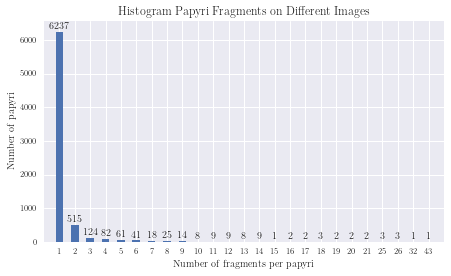

In [143]:
get_cleand_papyri_hist(processed_frame, title = 'Histogram Papyri Fragments on Different Images', fig_name= 'HistogramFrag_1.pdf')

In [249]:
def create_train_val_test_frames(processed_frame):
    id_series = processed_frame.groupby('papyPosID')['fnames'].nunique().sort_values(ascending=False)
    id_frame = pd.DataFrame(id_series)
    base_line_papyris = id_frame[id_frame.fnames != 1].index
    df = processed_frame[processed_frame['papyPosID'].isin(base_line_papyris)]
    
    get_cleand_papyri_hist(df, title = 'Histogram Fragments / Papyri  [removed papyris with just on fragment]', fig_name= 'HistogramFragAfter_2.pdf')
    
    id_series = df.groupby('papyPosID')['fnames'].nunique().sort_values(ascending=False)
    counts = np.bincount(id_series)

    def remove_empty_bins(counts):
        ticks = range(len(counts))
        new_ticks = []
        new_counts = []
        for tick, count in zip(ticks, counts):
            if count != 0:
                new_ticks.append(str(tick))
                new_counts.append(count)
        return new_ticks, new_counts

    frags_per_papyri, counts = remove_empty_bins(counts)
    
    train_ids = []
    val_ids = []
    test_ids = []

    for frag_per_papyri in frags_per_papyri:
        id_series = df.groupby('papyPosID')['fnames'].nunique().sort_values(ascending=False)
        ids = id_frame[id_frame.fnames == int(frag_per_papyri)].index
        if len(ids) <= 3:
            train_ids.append(ids[0])
        else:
            train, test = train_test_split(ids, test_size=0.1, random_state=44)
            train, val = train_test_split(train, test_size=0.11, random_state=44)
            train_ids = list(itertools.chain(train_ids, train))
            val_ids = list(itertools.chain(val_ids, val))
            test_ids = list(itertools.chain(test_ids, test))
            
    print(f'# of IDs in train = {len(train_ids)}')
    print(f'# of IDs in val = {len(val_ids)}')
    print(f'# of IDs in test = {len(test_ids)}')
    
    train_frame = df[df['papyPosID'].isin(train_ids)]
    val_frame = df[df['papyPosID'].isin(val_ids)]
    test_frame = df[df['papyPosID'].isin(test_ids)]
    
    print(f'# of IDs in train = {len(train_frame.papyPosID.unique())}')
    print(f'# of IDs in val = {len(val_frame.papyPosID.unique())}')
    print(f'# of IDs in test = {len(test_frame.papyPosID.unique())}')
    
    get_cleand_papyri_hist(train_frame, title = 'Histogram Fragments / Papyri  [Train]', fig_name= 'HistogramFragAfterTrain.pdf')
    get_cleand_papyri_hist(val_frame, title = 'Histogram Fragments / Papyri  [Val]', fig_name= 'HistogramFragAfterVal.pdf')
    get_cleand_papyri_hist(test_frame, title = 'Histogram Fragments / Papyri  [Test]', fig_name= 'HistogramFragTest.pdf')
    
    return train_frame, val_frame, test_frame

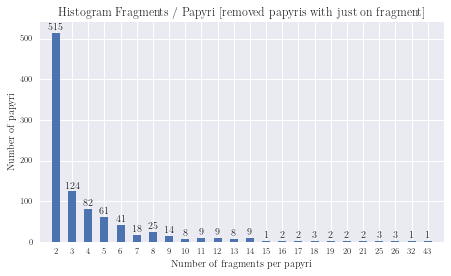

# of IDs in train = 741
# of IDs in val = 95
# of IDs in test = 98
# of IDs in train = 741
# of IDs in val = 95
# of IDs in test = 98


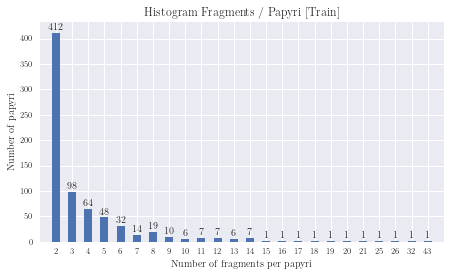

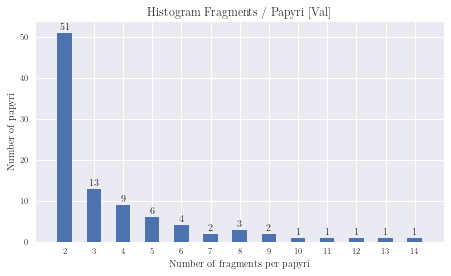

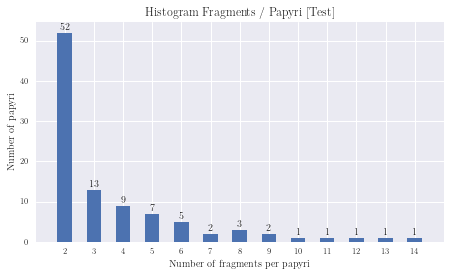

In [250]:
train_frame, val_frame, test_frame = create_train_val_test_frames(processed_frame)

In [260]:
def copy_train_images(name):
    src = '/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing/' + name + '.png'
    dst = '/Users/beantown/PycharmProjects/master-thesis/data/processed/04_train/' + name+ '.png'
    copyfile(src,dst)
    
def copy_val_images(name):
    src = '/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing/' + name+ '.png'
    dst = '/Users/beantown/PycharmProjects/master-thesis/data/processed/05_val/' + name+ '.png'
    copyfile(src,dst)
    
def copy_test_images(name):
    src = '/Users/beantown/PycharmProjects/master-thesis/data/processed/03_post_cleansing/' + name+ '.png'
    dst = '/Users/beantown/PycharmProjects/master-thesis/data/processed/06_test/' + name+ '.png'
    copyfile(src,dst)

In [261]:
train_frame.fnames.progress_apply(copy_train_images)
val_frame.fnames.progress_apply(copy_val_images)
test_frame.fnames.progress_apply(copy_test_images)

  0%|          | 0/360 [00:00<?, ?it/s]

27      None
59      None
173     None
180     None
251     None
        ... 
9845    None
9855    None
9928    None
9929    None
9936    None
Name: fnames, Length: 360, dtype: object

In [263]:
train_frame.to_csv('/Users/beantown/PycharmProjects/master-thesis/data/processed/04_train/processed_info.csv')
val_frame.to_csv('/Users/beantown/PycharmProjects/master-thesis/data/processed/05_val/processed_info.csv')
test_frame.to_csv('/Users/beantown/PycharmProjects/master-thesis/data/processed/06_test/processed_info.csv')

In [264]:
train_frame

,fnames_raw,fnames,fragmentID,papyID,posinfo,pixelCentimer,Simpleposinfo,papyPosID
2,14800_6595BV,1_14800_6595BV,1,14800,BV,229.988002,v,14800v
11,16876_5869Z29R,1_16876_5869Z29R,1,16876,ZR,228.691150,r,16876r
13,14022_4919R,1_14022_4919R,1,14022,R,231.296890,r,14022r
14,13796_4715CR,2_13796_4715CR,2,13796,CR,195.211466,r,13796r
19,13916_4807DR,3_13916_4807DR,3,13916,DR,230.425208,r,13916r
...,...,...,...,...,...,...,...,...
9958,16613_3520_P19_64,2_16613_3520_P19_64,2,16613,P,193.905976,v,16613v
9960,12208_4279MR,0_12208_4279MR,0,12208,MR,229.994605,r,12208r
9962,13899_4801DV,7_13899_4801DV,7,13899,DV,227.818488,v,13899v
9963,13392_4492BR,1_13392_4492BR,1,13392,BR,230.428874,r,13392r
